# Configuració entorn GPU

In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Càrrega dades

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'dataBalanced' 

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
BATCH_SIZE = 16
IMG_SIZE = (256, 256)

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1168 files belonging to 2 classes.


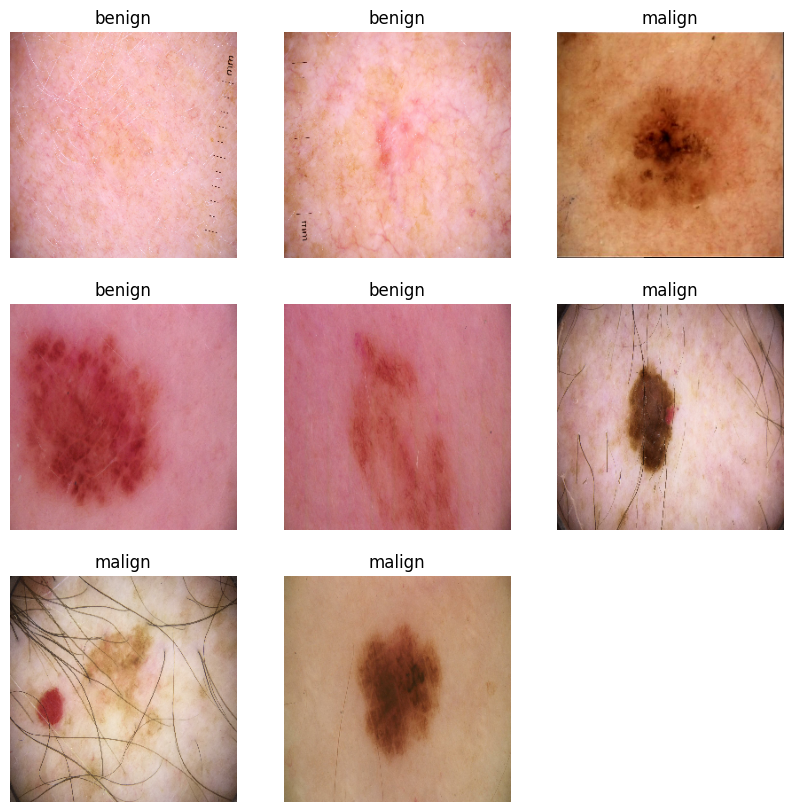

In [8]:
class_names = data.class_names

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Divisió dataset

In [9]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val.prefetch(buffer_size=AUTOTUNE)
test_dataset = test.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [13]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [14]:
rescale = tf.keras.layers.Rescaling(scale=1./255)

# Elaboració Model

In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.densenet.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 8, 8, 1024)


In [17]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 64, 64, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 64, 64, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 64, 64, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 32, 32, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 32, 32, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 32, 32, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 32, 32, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 32, 32, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 32, 32, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 32, 32, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 16, 16, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 16, 16, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 16, 16, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 16, 16, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 16, 16, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 16, 16, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 16, 16, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 16, 16, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 16, 16, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 16, 16, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 16, 16, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 16, 16, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 8, 8, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 8, 8, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 8, 8, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 8, 8, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 8, 8, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 8, 8, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 8, 8, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1024)


In [19]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [20]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        703750

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
len(model.trainable_variables)

364

# Entrenament

In [24]:
initial_epochs = 15

#loss0, accuracy0 = model.evaluate(train_dataset)

In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
58/58 [==============================] - 18s 211ms/step - loss: 0.6305 - accuracy: 0.6562 - val_loss: 0.5324 - val_accuracy: 0.7321
Epoch 2/15
58/58 [==============================] - 12s 198ms/step - loss: 0.5716 - accuracy: 0.7123 - val_loss: 0.5445 - val_accuracy: 0.7054
Epoch 3/15
58/58 [==============================] - 12s 197ms/step - loss: 0.5186 - accuracy: 0.7414 - val_loss: 0.5493 - val_accuracy: 0.7500
Epoch 4/15
58/58 [==============================] - 12s 203ms/step - loss: 0.5293 - accuracy: 0.7252 - val_loss: 0.5636 - val_accuracy: 0.6964
Epoch 5/15
58/58 [==============================] - 13s 223ms/step - loss: 0.4963 - accuracy: 0.7662 - val_loss: 0.5928 - val_accuracy: 0.6429
Epoch 6/15
58/58 [==============================] - 13s 224ms/step - loss: 0.4692 - accuracy: 0.7694 - val_loss: 0.5176 - val_accuracy: 0.7143
Epoch 7/15
58/58 [==============================] - 13s 225ms/step - loss: 0.4773 - accuracy: 0.7705 - val_loss: 0.6658 - val_accuracy: 0.6250

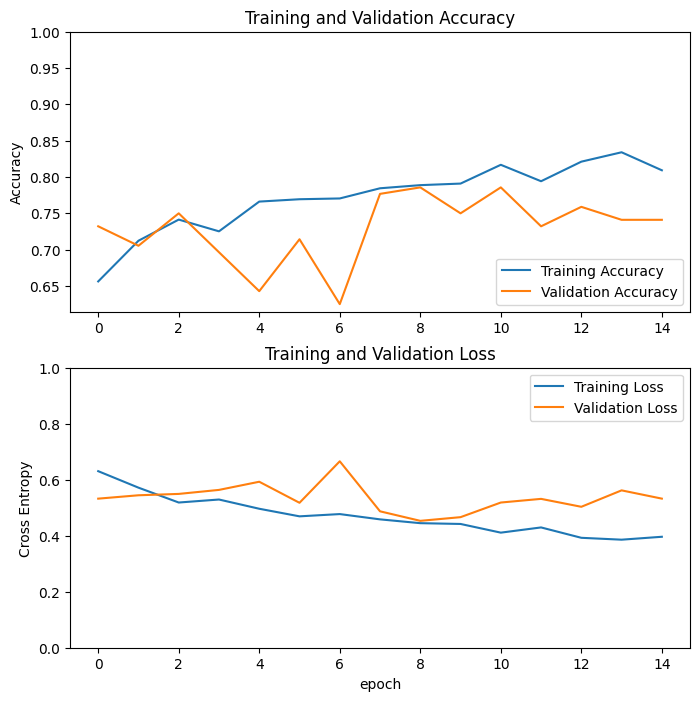

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Avaluació

In [27]:
loss, accuracy = model.evaluate(test_dataset)

7/7 [==============================] - 4s 47ms/step - loss: 0.4897 - accuracy: 0.7679


In [28]:
from tensorflow.keras.metrics import Precision, Recall, AUC
pre = Precision()
re = Recall()
auc = AUC()
y_vec = []
yhat_vec = []
for batch in test_dataset.as_numpy_iterator(): 
    X, y = batch
    y_vec.append(y)
    #print(y)
    yhat = model.predict(X)
    yhat_vec.append(yhat)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    auc.update_state(y, yhat)

1/1 [==============================] - 0s 47ms/step


In [29]:
print(pre.result(), re.result(),auc.result())

tf.Tensor(0.7733333, shape=(), dtype=float32) tf.Tensor(0.90625, shape=(), dtype=float32) tf.Tensor(0.83837897, shape=(), dtype=float32)


In [30]:
precision = 0.7733333
recall = 0.90625
F1 = 2/((1/precision)+(1/recall))
print(F1)

0.8345323546917859
